In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import json
from pprint import pprint

In [2]:
json_path="./data/implementations.json"
with open(json_path) as f:
    data = json.load(f)

In [3]:
mandelbrot32 = []
mandelbrot64 = []
simd32 = []
simd64 = []

for d in data["datapoints"]:
    avg_time = np.asarray(list(map(lambda x: x["computationTime"],
                   d["data"]["workers"])))
    avg_time = np.average(avg_time)
    if d["implementation"] == "mandelbrot32":
        mandelbrot32.append(avg_time)
    elif d["implementation"] == "mandelbrot64":
        mandelbrot64.append(avg_time)
    elif d["implementation"] == "mandelbrotsimd32":
        simd32.append(avg_time)
    elif d["implementation"] == "mandelbrotsimd64":
        simd64.append(avg_time)

# time in ms
mandelbrot32 = np.asarray(mandelbrot32) / 1000
mandelbrot64 = np.asarray(mandelbrot64) / 1000
simd32 = np.asarray(simd32) / 1000
simd64 = np.asarray(simd64) / 1000
print(mandelbrot32, mandelbrot64, simd32, simd64)

[ 309.03172222  167.60808333  109.32025    2672.17625     293.86222222
  714.48197222  313.45572222  309.54027778] [ 312.33083333  168.7285      110.20788889 2691.15938889  294.95219444
  718.17897222  314.98569444  311.167     ] [ 156.82894444  101.84386111   76.98258333 1080.27825     164.49177778
  319.32461111  159.92294444  156.68011111] [ 257.97530556  146.77105556   99.02988889 2101.53552778  254.02697222
  577.66858333  261.24738889  257.79422222]


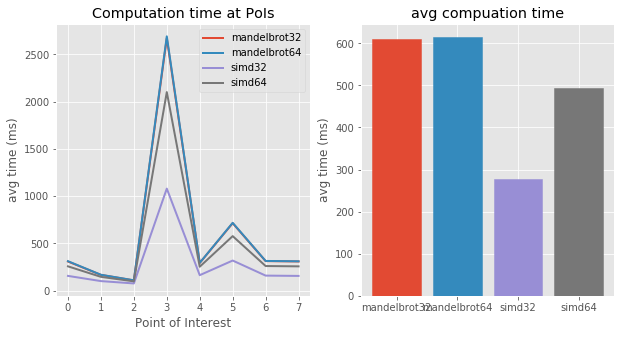

In [4]:
# Data for plotting
x = np.arange(len(simd64))
names = ["mandelbrot32", "mandelbrot64", "simd32", "simd64"]

plt.style.use('ggplot')
fig, (line, bar) = plt.subplots(1, 2, figsize=(10,5))
p0 = line.plot(x, mandelbrot32, label=names[0], lw=2)
p1 = line.plot(x, mandelbrot64, label=names[1], lw=2)
p2 = line.plot(x, simd32, label=names[2], lw=2)
p3 = line.plot(x, simd64, label=names[3], lw=2)
line.legend()

line.set(xlabel='Point of Interest', ylabel='avg time (ms)',
       title='Computation time at PoIs')
line.grid(True)

avg = np.asarray([np.average(mandelbrot32), np.average(mandelbrot64), np.average(simd32), np.average(simd64)])
x_avg = np.arange(len(avg))

barlist = bar.bar(x_avg, avg)
# set colors of bars to match colors in line plot
barlist[0].set_color(p0[0].get_color())
barlist[1].set_color(p1[0].get_color())
barlist[2].set_color(p2[0].get_color())
barlist[3].set_color(p3[0].get_color())

bar.set_xticks(x_avg)
bar.set_xticklabels(names)
bar.set(ylabel="avg time (ms)",
       title="avg compuation time")
bar.grid(True)

# fig.savefig("impl_test.svg", format="svg")
plt.show()